# Power reactor data

The PRIS database does not have a file available for download, so we must fetch it from the internet and construct our database. The below code is tested on Windows OS.

In [ ]:
import subprocess
import time
import re

def fetch_html_powershell(url):
    ps_command = (
        f'$resp = Invoke-WebRequest -Uri "{url}" -UseBasicParsing; '
        f'[Console]::OutputEncoding = [System.Text.Encoding]::UTF8; '
        f'$resp.Content'
    )

    result = subprocess.run(
        ["powershell", "-Command", ps_command],
        capture_output=True,
        text=True,
        encoding="utf-8",  # force utf-8 interpretation of output
        errors="replace"   # replace problematic characters
    )
    
    return result.stdout

def get_dates(html):
    pattern = r'\b\d{4}-(?:0[1-9]|1[0-2])-(?:0[1-9]|[12]\d|3[01])\b'

    for i,line in enumerate(html.strip().split()):
        if "<h3>Reactors</h3>" in line:
            reducedtext=''
            j=i
            while "</table>" not in html.strip().split()[j]:
                reducedtext+=html.strip().split()[j]
                j+=1
    dates = re.findall(pattern, reducedtext)
    return dates

def get_next(html):
    for i,line in enumerate(html.strip().split()):
        if "next" in line:
            nexturl=html.strip().split()[i-6]
    nextcountry=nexturl.split('=')[-1][:-1]#drop href, take only country name without '"'
    return nextcountry

#URL stem
website='https://pris.iaea.org/PRIS/CountryStatistics/CountryDetails.aspx?current='


In [ ]:
country='AR'
reactors={}
while country not in reactors:
    print('Fetching ',country)
    webcontent=fetch_html_powershell(website+country)
    dates=get_dates(webcontent)
    print(dates)
    reactors[country]=dates
    country=get_next(webcontent)
    time.sleep(5)#let's not make anyone angry at the IAEA and wait politely!

In [ ]:
#save this for later use
import json
with open('power_reactors.json', "w") as f:
    json.dump(reactors, f, indent=4)

# Research reactor data

This you can download from IAEA RRDB and save as an excelsheet. Then convert it to a csv file (separate with commas for the code to work, and leave the header). The csv is not included here due to possible copyright issues. We could use Pandas for the xls/csv reading, but for simplicity let's use pure python.

In [1]:
with open('ReactorList.csv','r') as f:
    rreactors=f.readlines()
rrdate=[]
lowrrdate=[]
for rreac in rreactors[2:]:
    rreacdata = rreac.strip().split(',')
    if rreacdata[-1]!='NA':
        year=int(rreacdata[-1].split('-')[0])
        if year<2026: #skip future reactors where they have a date
            rrdate.append(year)
        if float(rreacdata[-3])<10: #less then 500 kW reactors
            lowrrdate.append(year)
        #can add other filters of interest, country, reactor type etc.

# Counting by year

In [2]:
import json
#reading previously saved data
with open('power_reactors.json', "r") as f:
    reactors = json.load(f)

years=[]
for country in reactors:
    for date in reactors[country]:
        years.append(int(date[:4]))

from collections import Counter

PRyear_counts = Counter(years)
RRyear_counts = Counter(rrdate)
LRRyear_counts = Counter(lowrrdate)


# Plot

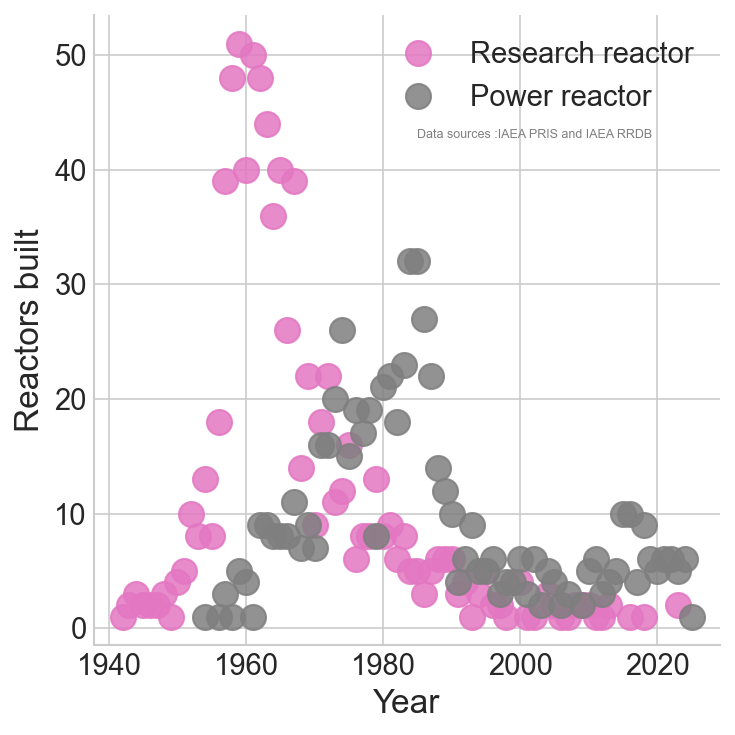

In [3]:
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8-whitegrid')

plt.figure(figsize=(5,5), dpi=150)

RR_color = '#e377c2'   # rose
PR_color = '#7f7f7f'   # soft charcoal


plt.plot(RRyear_counts.keys(), RRyear_counts.values(),
         'o', color=RR_color, markersize=12, alpha=0.85, label='Research reactor')

plt.plot(PRyear_counts.keys(), PRyear_counts.values(),
         'o', color=PR_color, markersize=12, alpha=0.85, label='Power reactor')

plt.xlabel('Year', fontsize=16)
plt.ylabel('Reactors built', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)

# remove unneeded spines
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.text(1985 , 43,
     'Data sources :IAEA PRIS and IAEA RRDB', 
         va='center', ha='left', color='gray', fontsize=6)

plt.tight_layout()
plt.savefig('ReactorsStat.png')
plt.show()
